# Project: Vehicle Detection 

This project builds a pipeline to detect vehicles from a car's front camera.

### Importing Packages

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
from lesson_functions import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import cv2
import pickle
import glob

%matplotlib inline

### Data Exploration

Exporing into image files and splitting it to trainning and test sets

There are 8792 car images
There are 8968 non_car images
Here's a few samples:


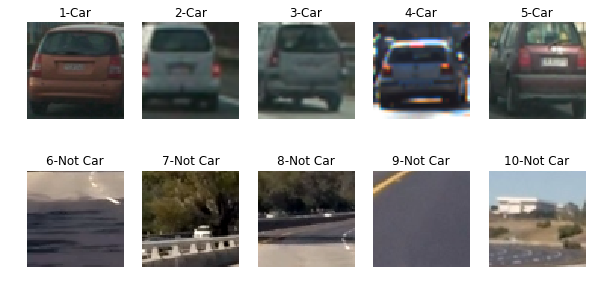

In [7]:
# Split files in 0.75/0.25 Train/Test
def file_split(path, rate=0.75):
    file = glob.glob(path + '/*.png')
    cut = int(rate*len(file))
    file1 = file[:cut]
    file2 = file[cut:]
    
    return file1, file2

car_train_file, car_test_file = [], []
not_car_train_file, not_car_test_file = [], []

for dir in glob.glob('data/vehicles/*'):
    file1, file2 = file_split(dir)
    car_train_file.extend(file1)
    car_test_file.extend(file2)

for dir in glob.glob('data/non-vehicles/*'):
    file1, file2 = file_split(dir)
    not_car_train_file.extend(file1)
    not_car_test_file.extend(file2)

print ('There are {} car images'.format((len(car_train_file)+len(car_test_file))))
print ('There are {} non_car images'.format((len(not_car_train_file)+len(not_car_test_file))))

print('Here\'s a few samples:')
# Image visualization
fig, axs = plt.subplots(2, 5, figsize=(10,5))
axs = axs.ravel()
for i in range(5):
    image1 = mpimg.imread(car_train_file[np.random.randint(0, len(car_train_file))])
    axs[i].axis('off')
    axs[i].set_title(str(i+1)+'-Car')
    axs[i].imshow(image1) 

for i in range(5,10):
    image2 = mpimg.imread(not_car_train_file[np.random.randint(0, len(not_car_train_file))])
    axs[i].axis('off')
    axs[i].set_title(str(i+1)+'-Not Car')
    axs[i].imshow(image2)

plt.savefig('output_images/car_notcar.png')
plt.show()

## 1. Histogram of Oriented Gradients (HOG)

#### 1.1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I used the functions from the lesson for features extraction (HOG, binned color and color histogram features). These functions are defined at lesson_functions.py

The code for this step uses the lesson_functions.py and an visualizing example is contained in the next code cell.

It's using the RGB color space and the following HOG parameters:
- orientations = 9
- pixels_per_cell = (8, 8)
- cells_per_block = (2, 2)

I then explored different color spaces and different get_hog_featuers() parameters (orientations, pixels_per_cell, and cells_per_block). I grabbed random images from each of the two classes and displayed them to get a feel for what the get_hog_featuers() output looks like.

Here's an example using these HOG parameters:

/Users/rafael/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


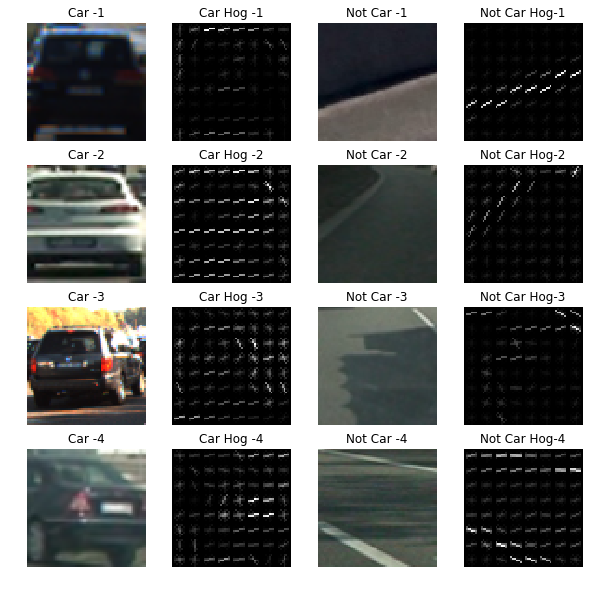

In [8]:
# Visualizing HOG examples
plt.figure(figsize=(10,10))
for i in range(4):
    car_img = mpimg.imread(car_train_file[np.random.randint(0, len(car_train_file))])
    car_hog = get_hog_features(car_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]
    noncar_img = mpimg.imread(not_car_train_file[np.random.randint(0, len(not_car_train_file))])
    noncar_hog = get_hog_features(noncar_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)[1]
    plt.subplot(4,4,4*i+1)
    plt.axis('off')
    plt.title('Car -'+ str(i+1))
    plt.imshow(car_img)
    plt.subplot(4,4,4*i+2)
    plt.axis('off')
    plt.title('Car Hog -'+ str(i+1))
    plt.imshow(car_hog, cmap='gray')
    plt.subplot(4,4,4*i+3)
    plt.axis('off')
    plt.title('Not Car -'+ str(i+1))
    plt.imshow(noncar_img)
    plt.subplot(4,4,4*i+4)
    plt.axis('off')
    plt.title('Not Car Hog-'+ str(i+1))
    plt.imshow(noncar_hog, cmap='gray')

plt.savefig('output_images/car_notcar_hog.png')
plt.show()

#### 1.2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and results shows that these parameter performs the best.

- color_space = 'YCrCb'
- spatial_size = (16, 16)
- hist_bins = 32
- orient = 9
- pix_per_cell = 8
- cell_per_block = 2
- hog_channel = 'ALL'
- spatial_feat = True
- hist_feat = True
- hog_feat = True

In [9]:
# Extract features
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()
car_train_f = extract_features(car_train_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

car_test_f = extract_features(car_test_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

noncar_train_f = extract_features(not_car_train_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

noncar_test_f = extract_features(not_car_test_file, color_space=color_space, spatial_size=spatial_size,
                               hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                               cell_per_block=cell_per_block, hog_channel=hog_channel, 
                               spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2=time.time()
print (round(t2-t, 2), 'Seconds to extract features')

/Users/rafael/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


233.75 Seconds to extract features


#### 1.3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I've trained a linear SVM with the default classifier parameters. Dataset was normalized and shuffled before training (see the next 2 code cells below). Using HOG features alone I was able to achieve a test accuracy of 98.47%.

In [10]:
# Create an array stack of feature vectors
# Normalize combineded data set and separate them again for trainning and test
X = np.vstack((car_train_f, noncar_train_f, car_test_f, noncar_test_f)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

l1 = len(car_train_f)
l2 = len(noncar_train_f)
l3 = len(car_test_f)
l4 = len(noncar_test_f)

X_train = np.vstack((scaled_X[:l1], scaled_X[l1:(l1+l2)]))
y_train = np.hstack((np.ones(l1), np.zeros(l2)))
X_test = np.vstack((scaled_X[(l1+l2):(l1+l2+l3)], scaled_X[(l1+l2+l3):]))
y_test = np.hstack((np.ones(l3), np.zeros(l4)))

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [11]:
# Train classifier with Linear SVC and check prediction
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 100

print('SVC model predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156
167.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9847
SVC model predicts:  [ 0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.]
For these 100 labels:  [ 0.  1.  1.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.
  1.  0.  0.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  0.  1.  0.  1.  0.  1.  0.  0.

## 2. Sliding Window Search

#### 2.1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I've adapted the sliding window function **find_cars**, from the lessons, to extract features using Hog Sub-sampling Window Search, and to also make some predictions. Later on we generate a list of boxes with predefined parameters and draw the list of boxes on an image. Again, these later functions are from the Udacity's lesson.

Searching area is limited to y position (400, 656), 3 windows scales (small=0.8, medium=1.5, and large=2.3) are used. Instead of overlap, 2 cells per step are used. 

All above numbers are settled after testing with different numbers on test image to reach out the best detection.

#### 2.2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to optimize the performance of your classifier?

As described above, I searched on three scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result. Here is an example image:

In [13]:
# Extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    car_windows = []
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return car_windows

/Users/rafael/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


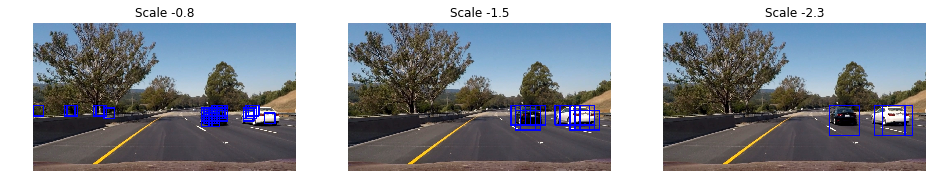

In [18]:
# Visualize Find Car function on test image, using scale 0.8, 1.5 and 2
image = mpimg.imread("test_images/test6.jpg")
#image = mpimg.imread("frame01sec.jpg")
draw_image = np.copy(image)
ystart = 400
ystop = 656
scales = [0.8, 1.5, 2.3]
hot_windows = []

plt.figure(figsize=(16,5))
for i, scale in enumerate(scales):
    car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    hot_windows.extend(car_windows)
    
    plt.subplot(1,3,i+1)
    plt.title('Scale -'+ str(scale))
    scale_img = draw_boxes(draw_image, car_windows, color=(0, 0, 255), thick=6)
    plt.axis('off')
    plt.imshow(scale_img)

plt.savefig('output_images/detect_car.png')
plt.show()

## 3. Video Implementation

#### 3.1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to the output video](./project_video_output.mp4)

#### 3.2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

On a single frame, heatmaps are created by adding up the detected car box. 

Then thresholds are set to filter out false positives. 

Final box were drew by function **draw_labeled_bboxes**. These code are in cell below and followed by an example of heatmap threshold and final draw box:

In [19]:
def add_heat(heatmap, bbox_list):
    # Loop through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Loop through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

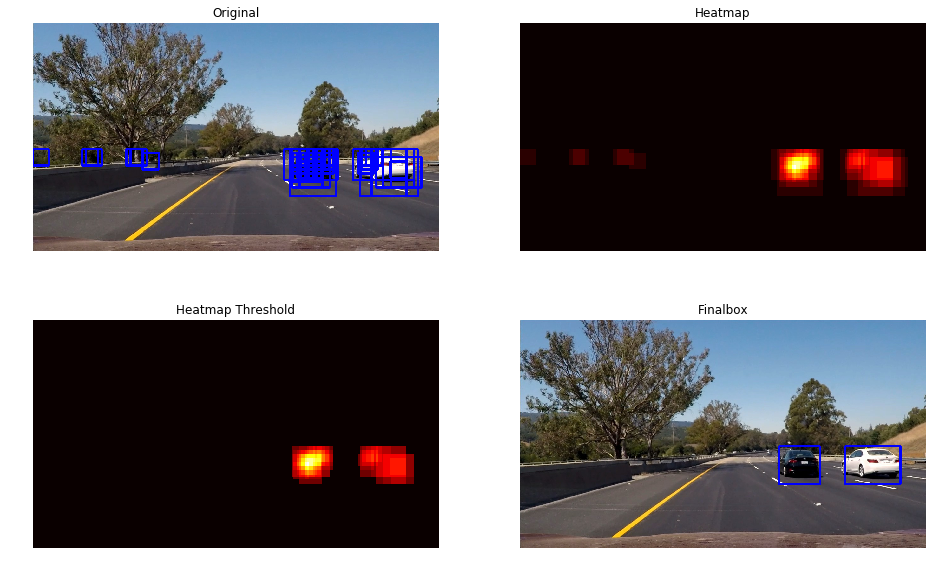

In [21]:
# Visualize Heatmap on test images
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
heatmap_img = np.zeros_like(image[:,:,0])
heatmap_img = add_heat(heatmap_img, hot_windows)

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
plt.title('Original')
plt.axis('off')
plt.imshow(window_img)

plt.subplot(2,2,2)
plt.title('Heatmap')
plt.axis('off')
plt.imshow(heatmap_img, cmap='hot')

plt.subplot(2,2,3)
heatmap_threshold = apply_threshold(heatmap_img, 2)
plt.title('Heatmap Threshold')
plt.axis('off')
plt.imshow(heatmap_threshold, cmap='hot')

plt.subplot(2,2,4)
labels = label(heatmap_threshold)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
plt.title('Finalbox')
plt.axis('off')
plt.imshow(draw_img)

plt.savefig('output_images/heatmap.png')
plt.show()

Here we load a function from the Project 4 **Advanced Lane Lines** to draw the lane lines along with vehicle detectation.

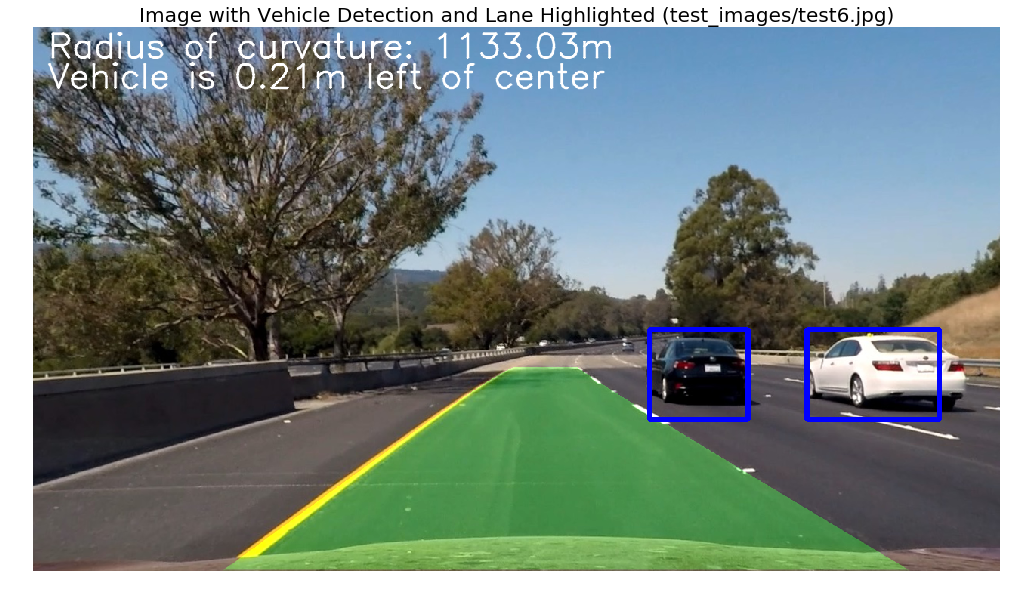

In [91]:
import lanelines
import imp
imp.reload(lanelines)
img_path = 'test_images/test6.jpg'
image = mpimg.imread(img_path)
image = lanelines.begin_draw_lane(image)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
lanelines.image_plotter(draw_img, title='Image with Vehicle Detection and Lane Highlighted ({})'.format(img_path))

For the video pipeline, I used a **Window_History** class. Class instance "history" will hold detected hot windows from the past 20 frames, then heatmap threshold and draw label box were implemented on top of the "history" instance. This process will make the detector more robust and stable.

In [94]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#Class holding hot window history from last 20 frames
class Window_History():
    def __init__(self):
        self.queue_len = 20
        self.win_history = []
    
    def add_hot_windows(self, hot_windows):
        if (len(self.win_history) == self.queue_len):
            self.win_history.pop(0)
        self.win_history.append(hot_windows)
    
    def get_all_windows(self):
        all_windows = []
        for windows in self.win_history:
            all_windows.extend(windows)
        
        return all_windows

# Processing pipeline
def image_pipeline(image):
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows = []
    for scale in scales:
        car_windows = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                cell_per_block, spatial_size, hist_bins)
        hot_windows.extend(car_windows)
    history.add_hot_windows(hot_windows)
    #print(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, history.get_all_windows())
    heatmap  = apply_threshold(heatmap,50)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    return window_image

def process_image(image):
    image_temp = lanelines.begin_draw_lane(image)
    result = image_pipeline(image_temp)
    return result

In [96]:
history = Window_History()
test_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [1:57:47<00:06,  6.32s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1h 50min 16s, sys: 4min 50s, total: 1h 55min 7s
Wall time: 1h 57min 51s


## 4. Discussion

#### 4.1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The final result is satisfied. Most of the problems were mainly concerned about detection accuracy. Balancing the accuracy of the classifier with execution speed was crucial. Here's a few pending challenges:

- When the car is far away, a smaller sampling rate has to be used but it will also bring in more false positives.
- Bounding box not always closely followed the the car image, there were missing detection on a few frames.

Given plenty of time to pursue it, a good approach would be to combine a very high accuracy classifier with high overlap in the search windows. The execution cost could be offset with more intelligent tracking strategies, such as:

- Determine vehicle location and speed to predict its location in subsequent frames
- Begin with expected vehicle locations and nearest (largest scale) search areas, and preclude overlap and redundant detections from smaller scale search areas to speed up execution
- Use a convolutional neural network (like YOLO or SSD), to preclude the sliding window search altogether